In [61]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sb
import scipy.stats as stats


## Task 1 

In [62]:
df = pd.read_csv('project1_data.csv', delimiter = ';')
array = df.to_numpy() 

print(f"Observations: {df.shape[0]}")

def check_missing_data(array):
    np.isnan(array).any()

print(
    "Is table missing any data? " + 
    ("Yes" if check_missing_data(array) else "No")
)

Observations: 450
Is table missing any data? No


There are 7 quantatative variables:
- weight
- height
- cats
- age
- income
- savings
- expenses

There are 3 qualitative variables:
- sex
- single
- place

Turns out that there are observations with negative values in expenses column. This does not seem to be correct. There shouldn't be a way to spend negative amount of money on food. Maybe some residents of Byteland didn't pay attention to the questions in a survey. I think it's best to treat these observations as invalid and drop them.

In [63]:
valid_observations = df[df.columns[-1]] > 0
df = df[valid_observations]

In [64]:
def plot_frequency_table(data, variable_name, is_qualitative):
    variable_data = data[variable_name]
    
    plt.figure(figsize = (10, 8))

    if is_qualitative:
        freq_table = variable_data.value_counts().reset_index()
        freq_table.columns = [variable_name, 'Frequency']
        freq_table['Percentage'] = freq_table['Frequency']
        freq_table['Percentage'] *= 100 / len(variable_data)
        
        sb.barplot(
            x = variable_name,
            y = 'Frequency',
            data = freq_table,
        )
        plt.xlabel(variable_name)
    
    else:
        intervals = pd.cut(variable_data, bins=10)
        freq_table = intervals.value_counts().reset_index()
        freq_table.columns = ['Interval', 'Frequency']
        freq_table['Percentage'] = freq_table['Frequency'] 
        freq_table['Percentage'] *= 100 / len(variable_data)
        
        freq_table = freq_table.sort_values(by = 'Interval')
        
        sb.barplot(
            x = freq_table['Interval'].astype(str),
            y = freq_table['Frequency'],
        )
        plt.xlabel("Interval")
    
    plt.title(f"Frequency Distribution of {variable_name}")
    plt.ylabel("Frequency")
    # so the intervals fit on the plot
    plt.xticks(rotation = 50)
    plt.show()

    return freq_table

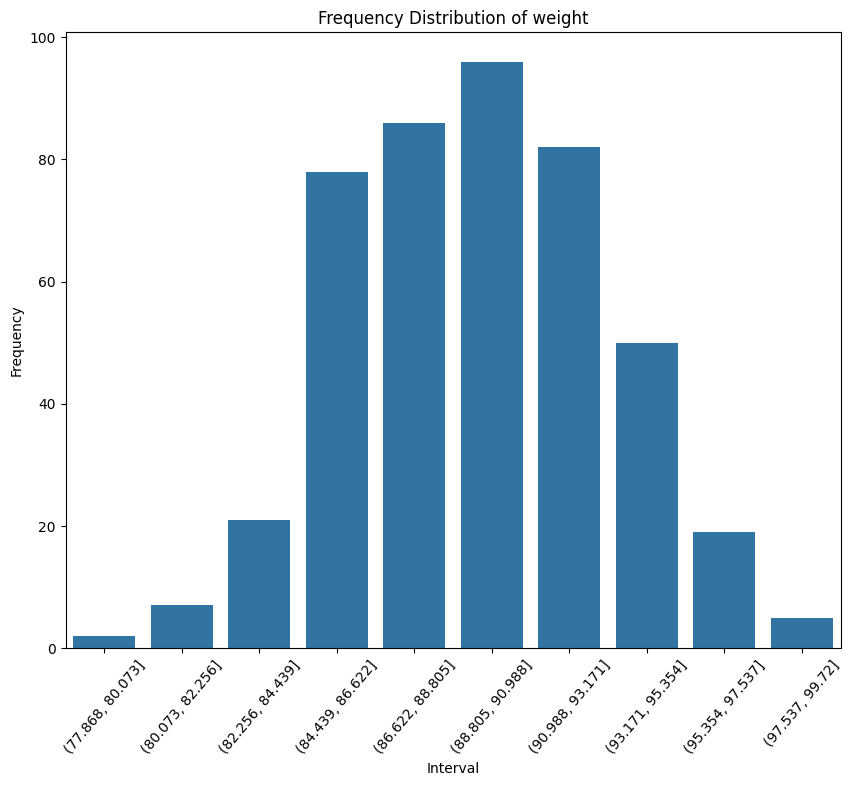

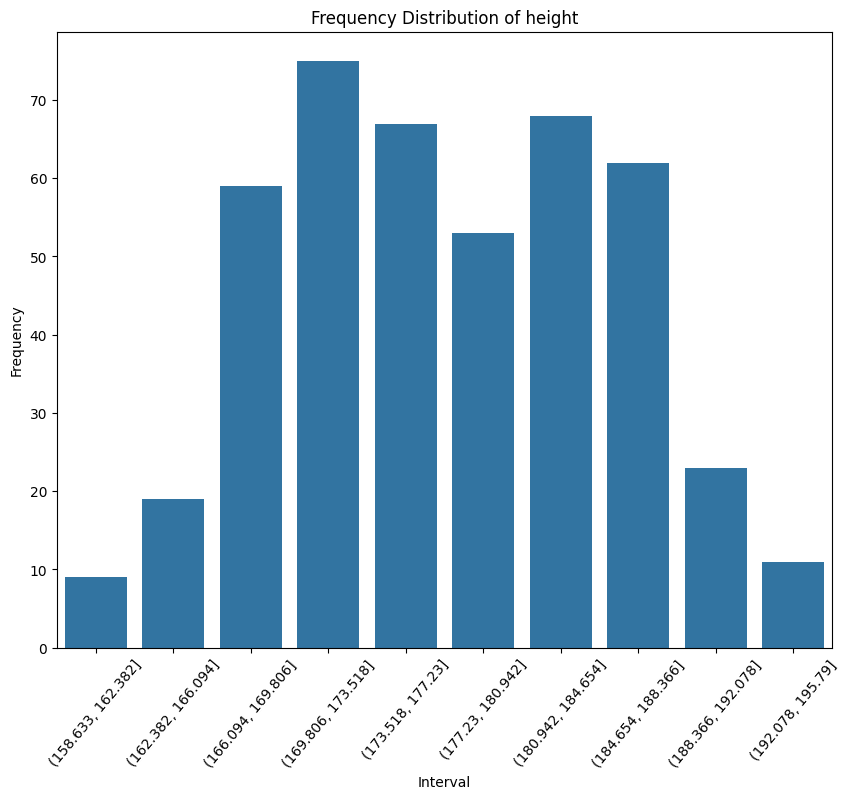

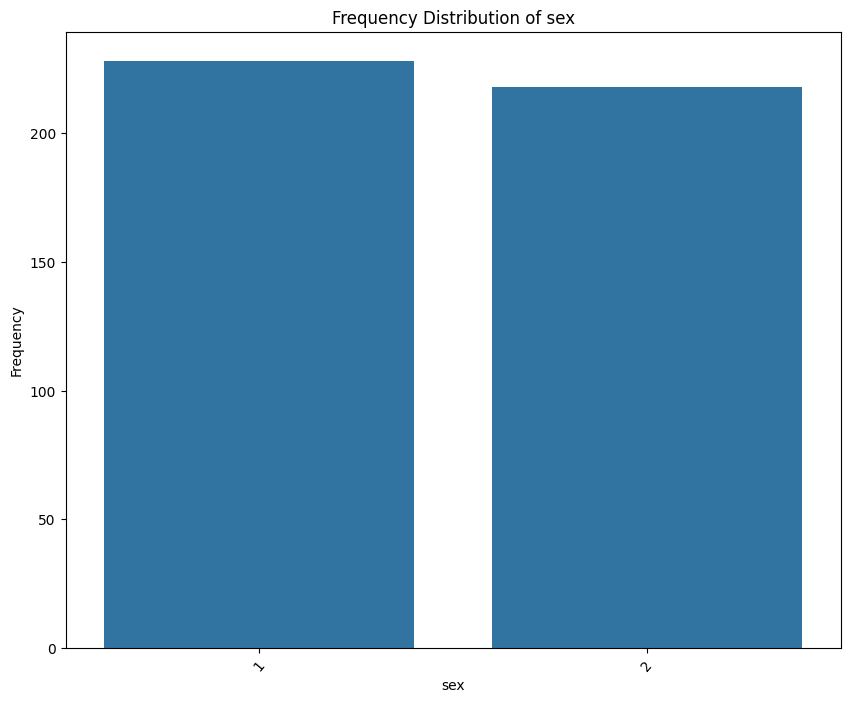

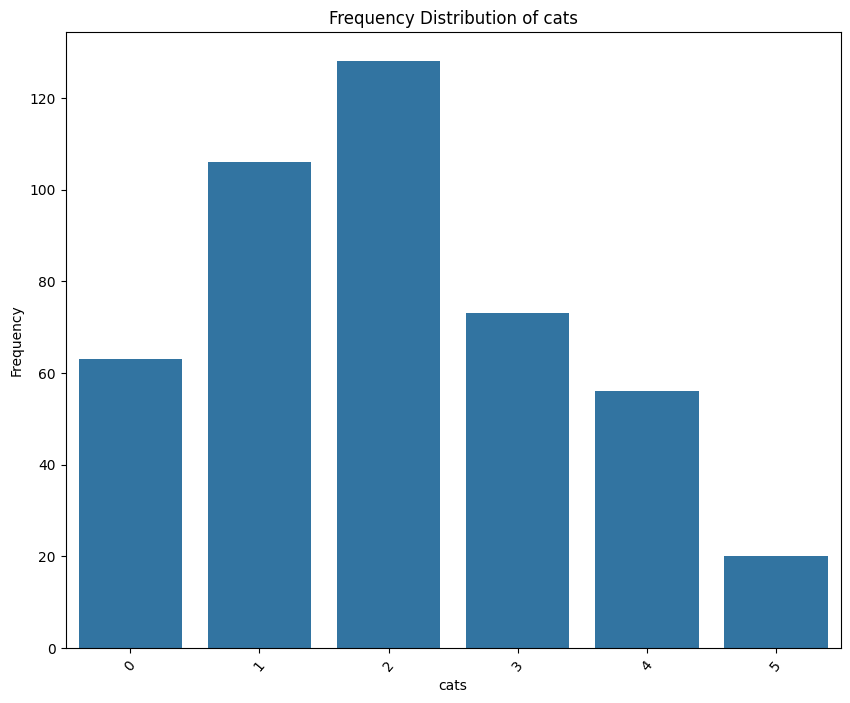

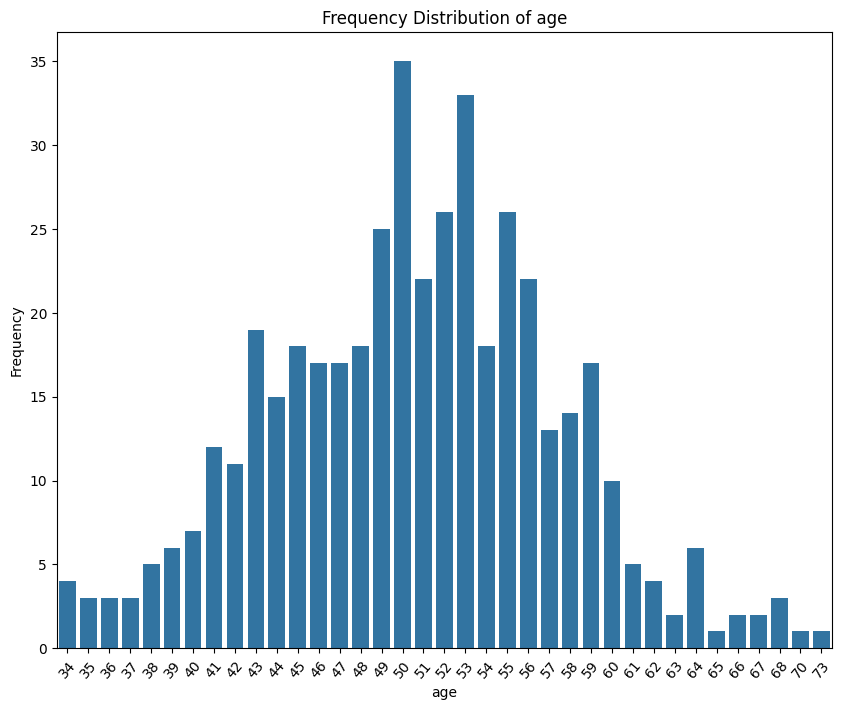

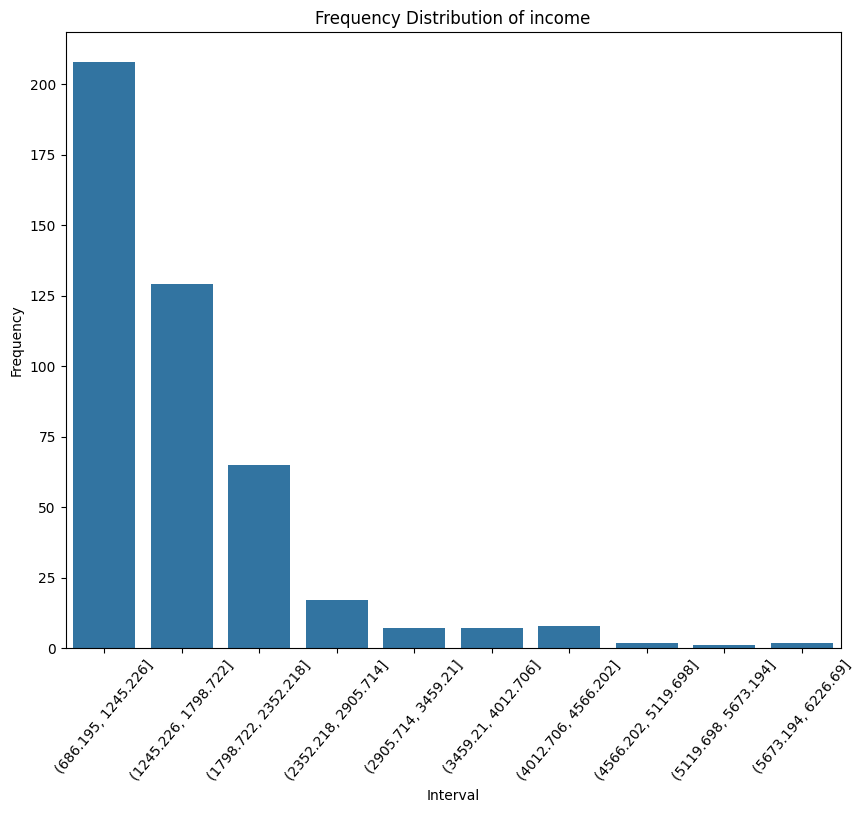

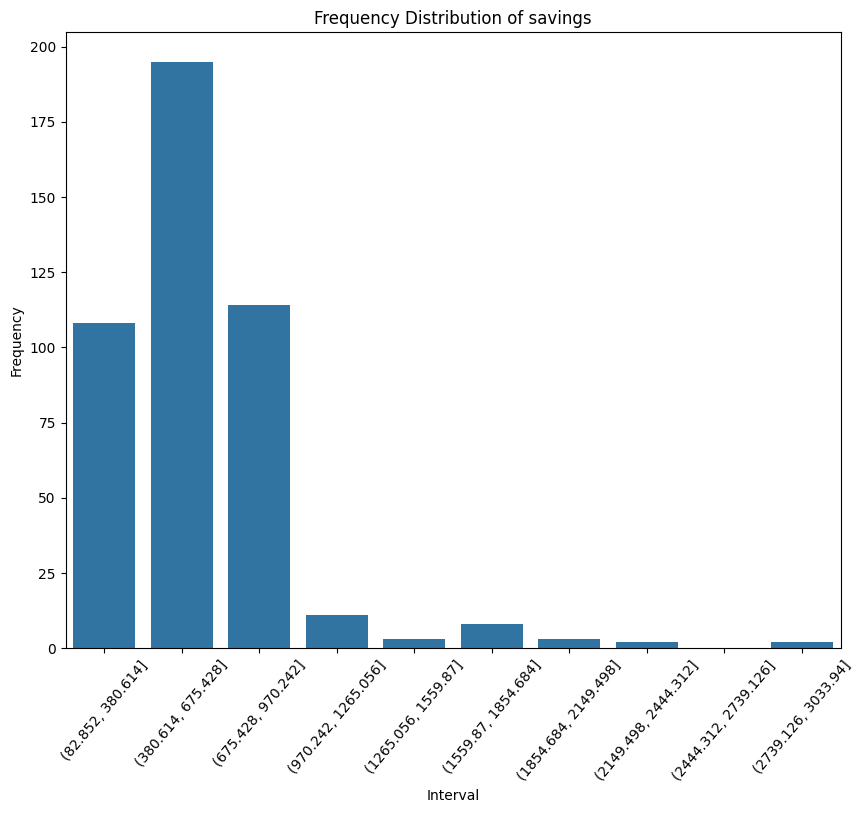

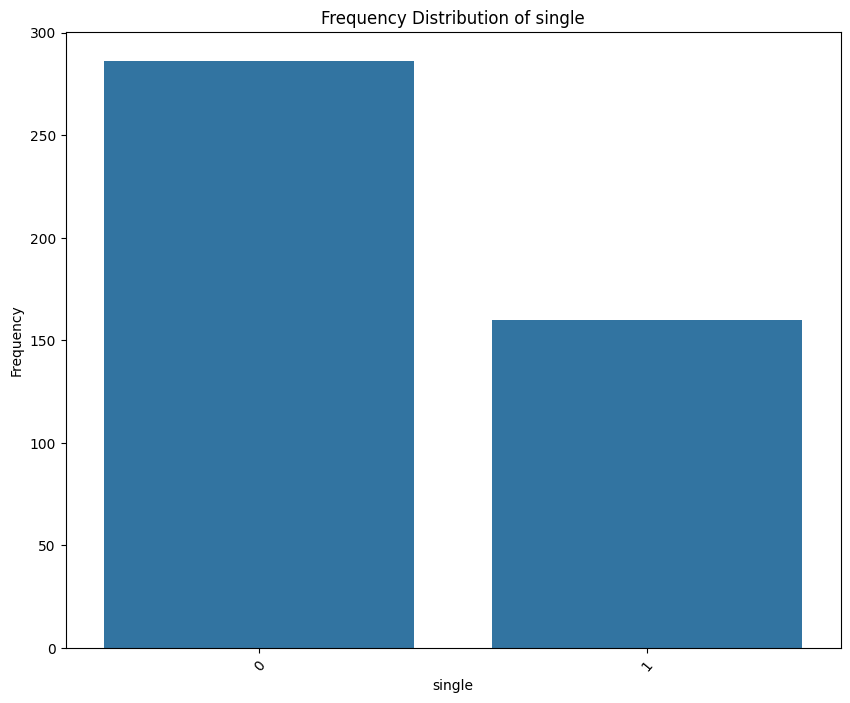

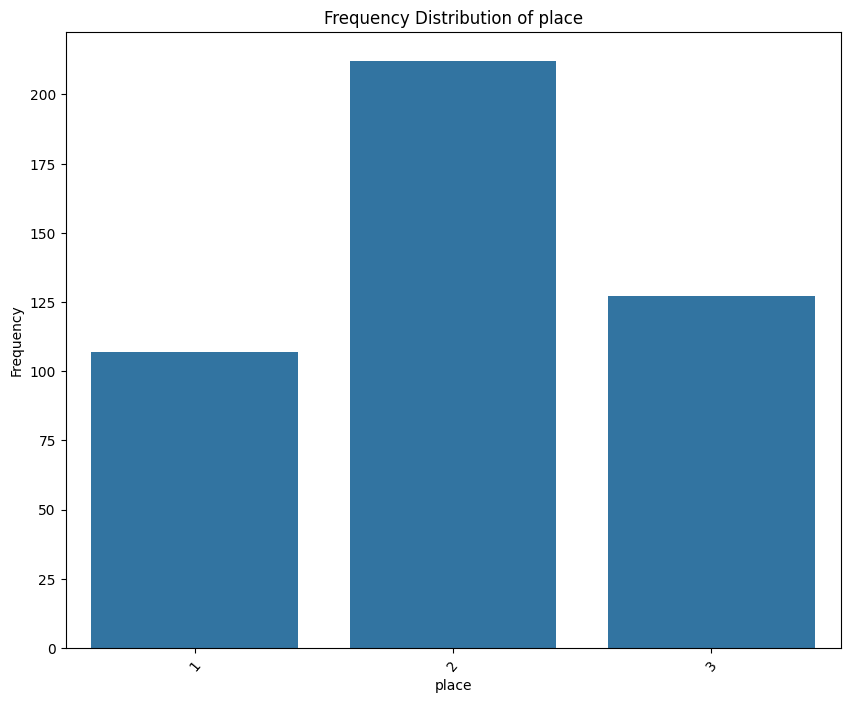

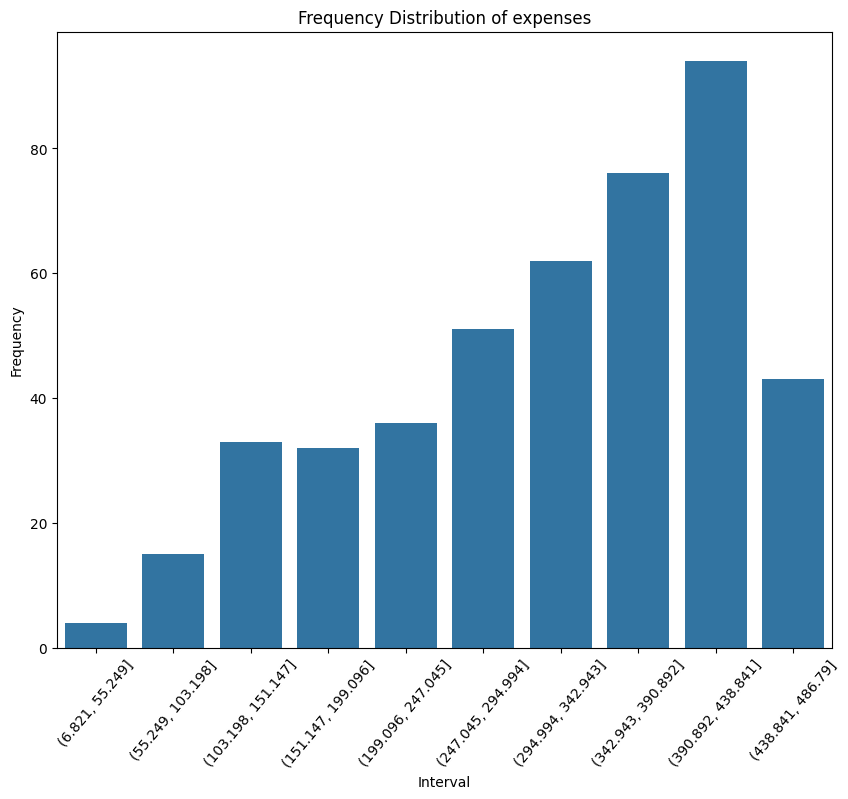

In [65]:
# age and cats aren't actually qual, but plots look nicer
is_quan = [True] * 2 + [False] + [True] * 4 + [False] * 2 + [True]
is_qual_plot = [i in [3,4] or not v for i, v in enumerate(is_quan)]
args = list(zip(df.columns[1:], is_qual_plot))

for col, is_qual in args:
    plot_frequency_table(df, col, is_qual)

In [66]:
args = list(zip(df.columns[1:], is_quan))
for col, iq in args:
    if iq:
        column = df[col]
        desc_stats = column.describe()
        print("Descriptive Statistics:\n", desc_stats, "\n")

Descriptive Statistics:
 count    446.000000
mean      89.475359
std        3.606364
min       77.890000
25%       86.830000
50%       89.420000
75%       92.030000
max       99.720000
Name: weight, dtype: float64 

Descriptive Statistics:
 count    446.000000
mean     177.322960
std        7.908077
min      158.670000
25%      170.790000
50%      176.675000
75%      183.935000
max      195.790000
Name: height, dtype: float64 

Descriptive Statistics:
 count    446.000000
mean       2.029148
std        1.369508
min        0.000000
25%        1.000000
50%        2.000000
75%        3.000000
max        5.000000
Name: cats, dtype: float64 

Descriptive Statistics:
 count    446.000000
mean      50.625561
std        6.846383
min       34.000000
25%       46.000000
50%       51.000000
75%       55.000000
max       73.000000
Name: age, dtype: float64 

Descriptive Statistics:
 count     446.000000
mean     1545.594596
std       805.260926
min       691.730000
25%      1048.792500
50%      12

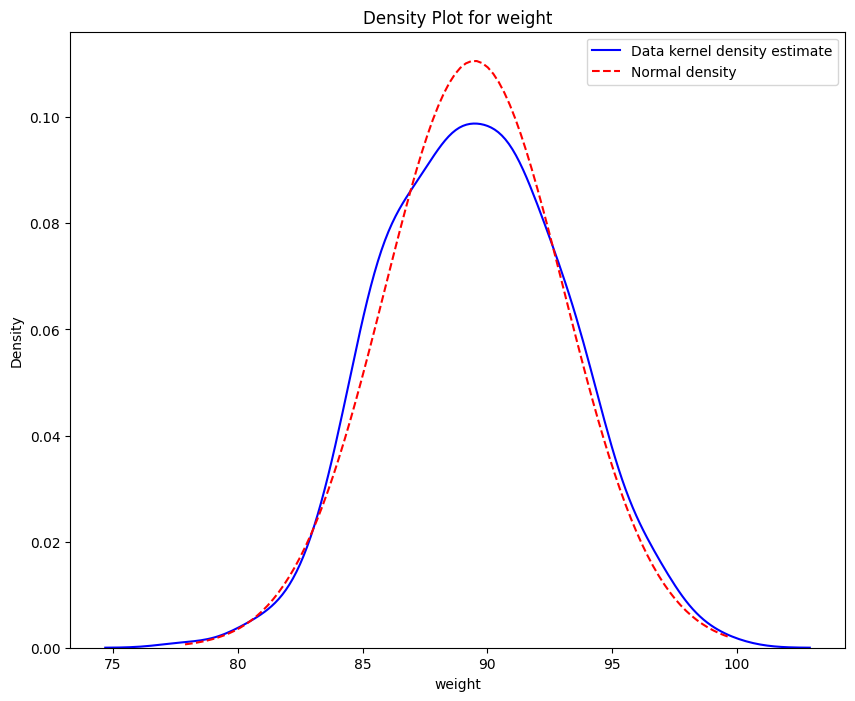

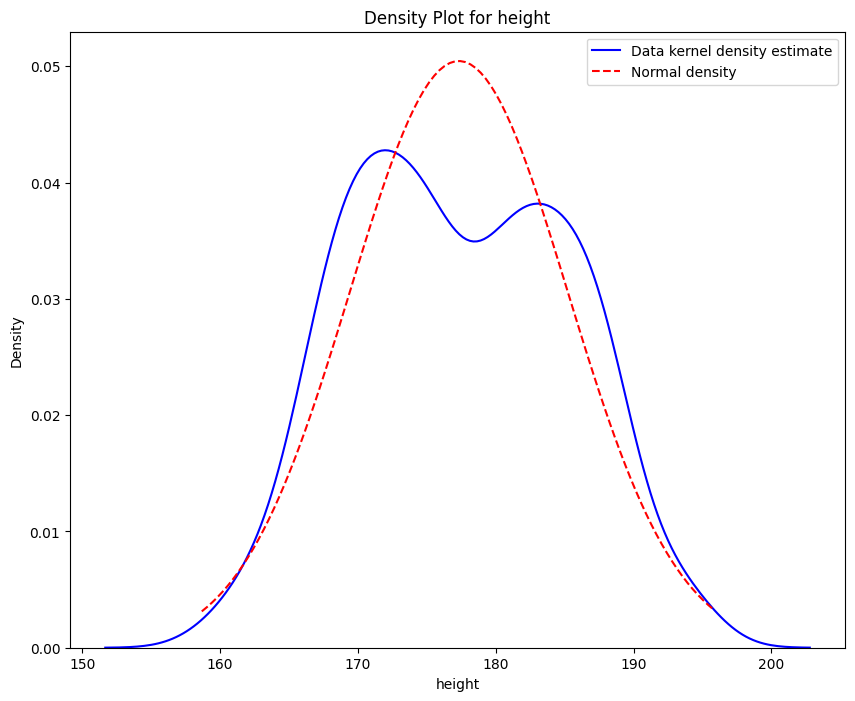

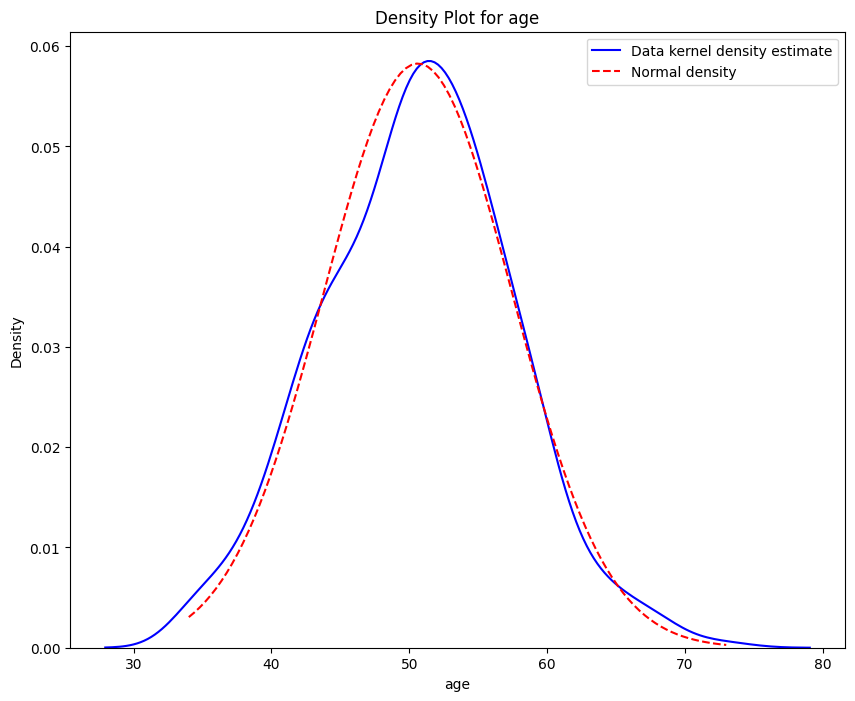

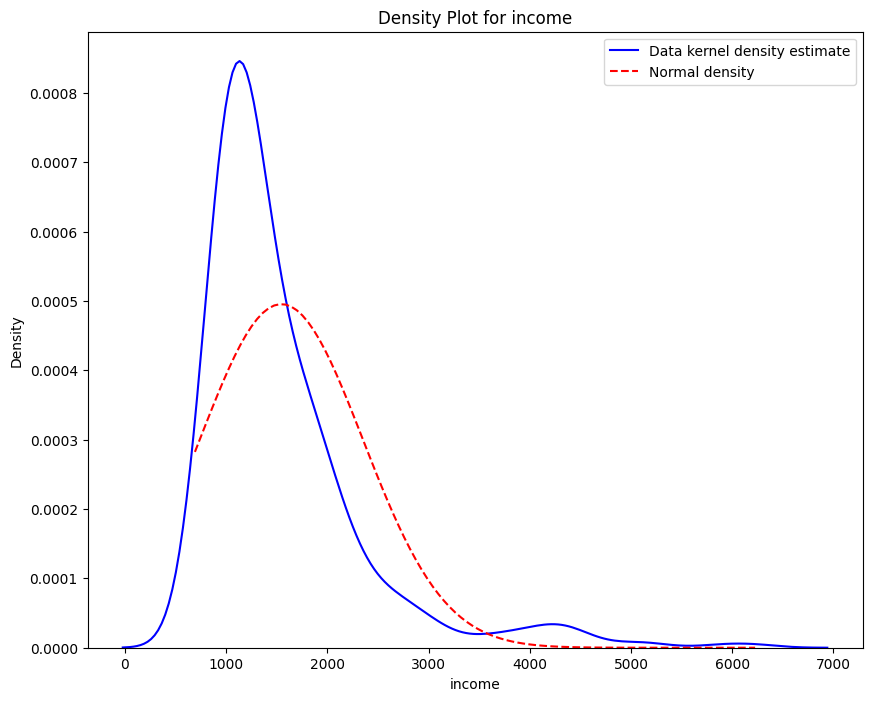

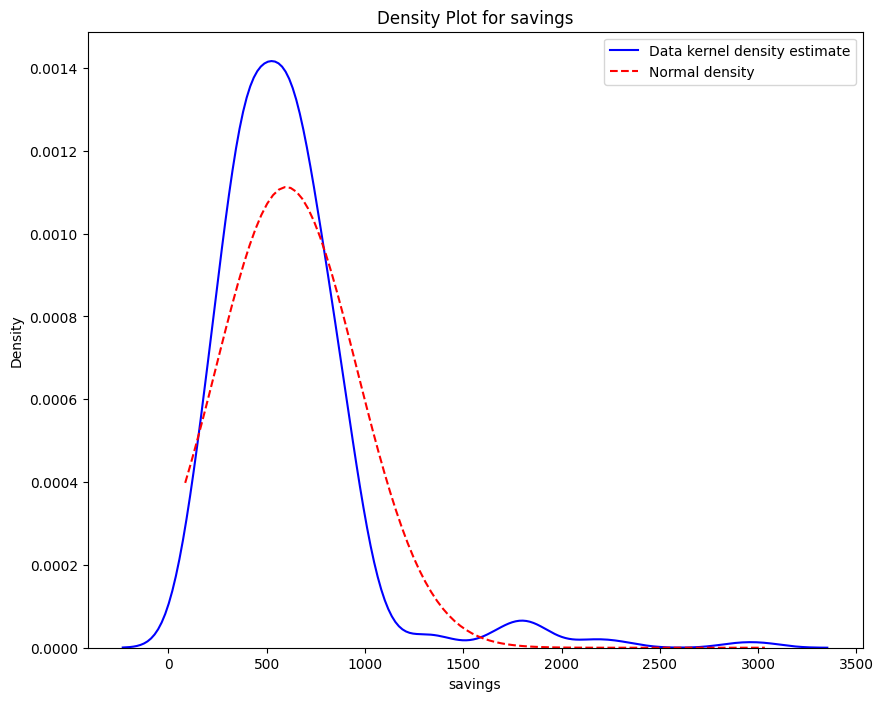

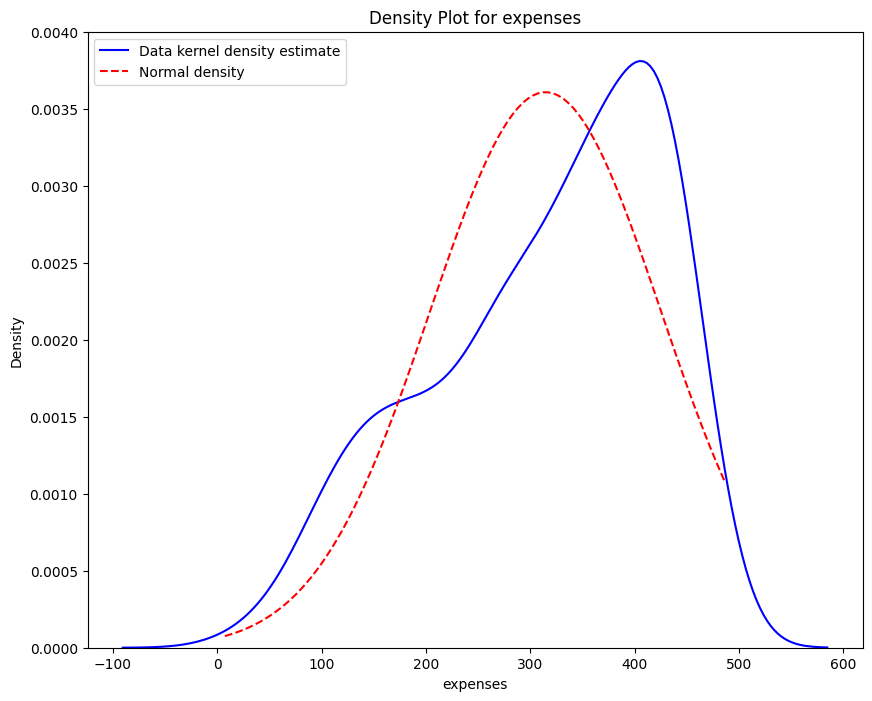

In [67]:
def compare_with_normal(data, column):
    # Density plot comparison
    variable = data[column] 
    mean, std = variable.mean(), variable.std()
    x = np.linspace(variable.min(), variable.max(), 100)
    plt.figure(figsize=(10, 8))

    sb.kdeplot(
        variable, 
        color='blue', 
        label='Data kernel density estimate',
    )
    plt.plot(
        x,
        stats.norm.pdf(x, mean, std),
        color='red',
        linestyle='--',
        label='Normal density',
    )

    plt.title(f"Density Plot for {column}")
    plt.legend()
    plt.show()
    

# Compare the distributions
for variable in ['weight', 'height', 'age', 'income', 'savings', 'expenses']:
    compare_with_normal(df, variable)


#### Comment

Plots for age and weight are close to normal distribution as expected. Plot for height has two peaks, and it can be related to the fact that byteland's female height distribution is different then male (but we would need to check if that is correct). Income plot is right-skewed with many outliers, creating long tails, as expected. Expenses distribution is also not that close to normal disribution. Probably expenses are correlated to income.

## Task 2

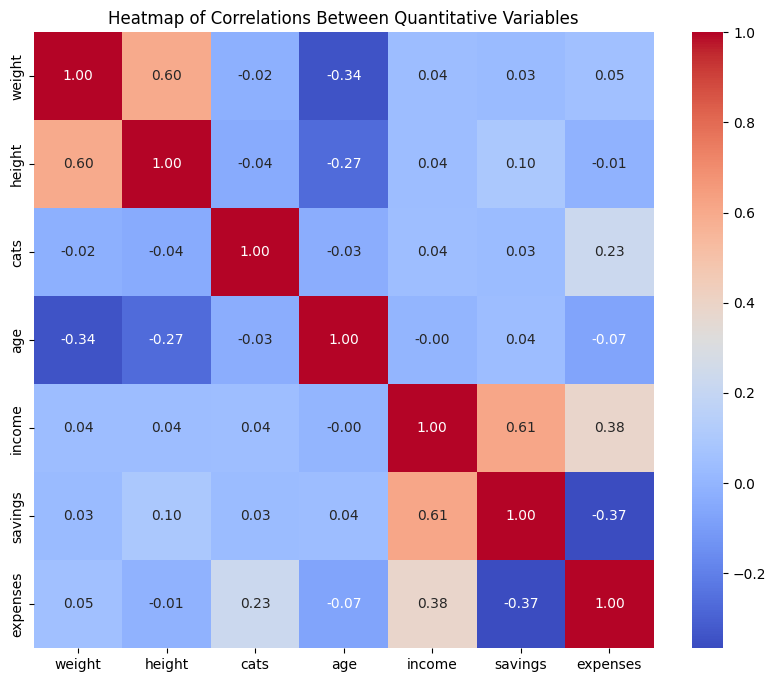

In [68]:
maplist = list(zip(df.columns[1:], is_quan))
quan_columns = [col for col, quan in maplist if quan]
corr_mat = df[quan_columns].corr()

def plot_heatmap(heatmap, title):
    plt.figure(figsize = (10, 8))
    sb.heatmap(heatmap, annot = True, cmap = 'coolwarm', fmt = ".02f")
    plt.title(title)
    plt.show()

plot_heatmap(corr_mat, "Heatmap of Correlations Between Quantitative Variables")

There seems to be correlation between person's height and weight and that seems reasonable. There's also negative correlation between person's age and their weight and height which can make sense, considering respondents are over 30 and mostly over 50 (from descriptive stats). There's obviously correlation between income and savings and expenses. There's also negative correlation between saving and expenses - the more you spend the less you save.

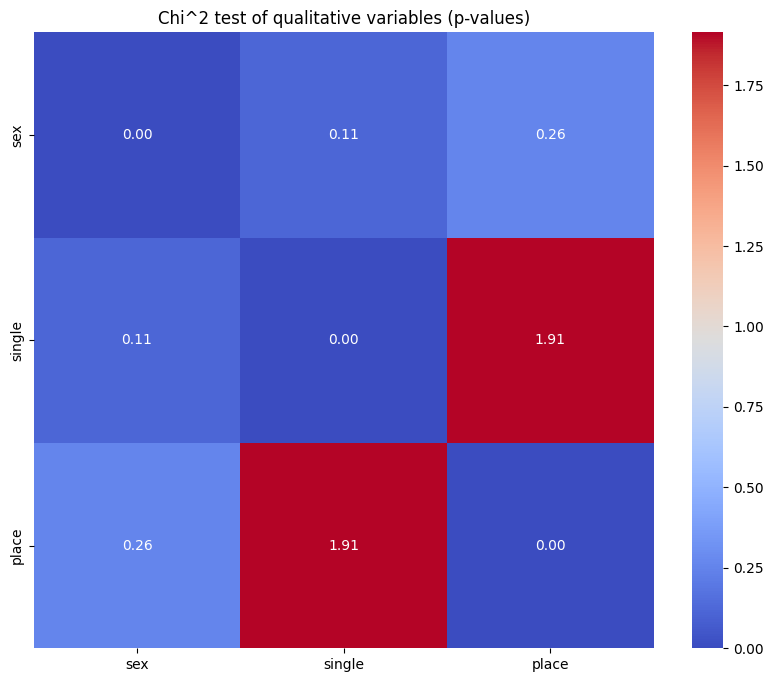

In [69]:
from scipy.stats import chi2_contingency

qual_columns = [col for col in df.columns[1:] if col not in quan_columns]
size = len(qual_columns)
p_results = np.zeros((size, size))

for i, x in enumerate(qual_columns):
    for j, y in enumerate(qual_columns):
        if x != y:
            crosstab = pd.crosstab(df[x], df[y])
            chi2, p, _, _ = chi2_contingency(crosstab)
            p_results[i][j] = chi2

p_results = pd.DataFrame(
    p_results,
    columns = qual_columns,
    index = qual_columns,
)

plot_heatmap(p_results, "Chi^2 test of qualitative variables (p-values)")

It doesn't seem like there are any correations here. It also seems logical, considering the variables.

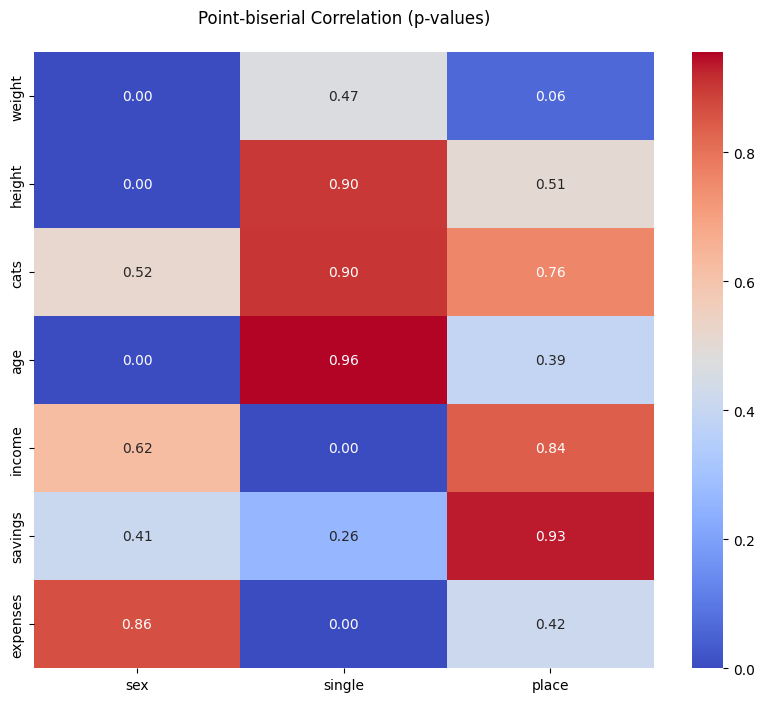

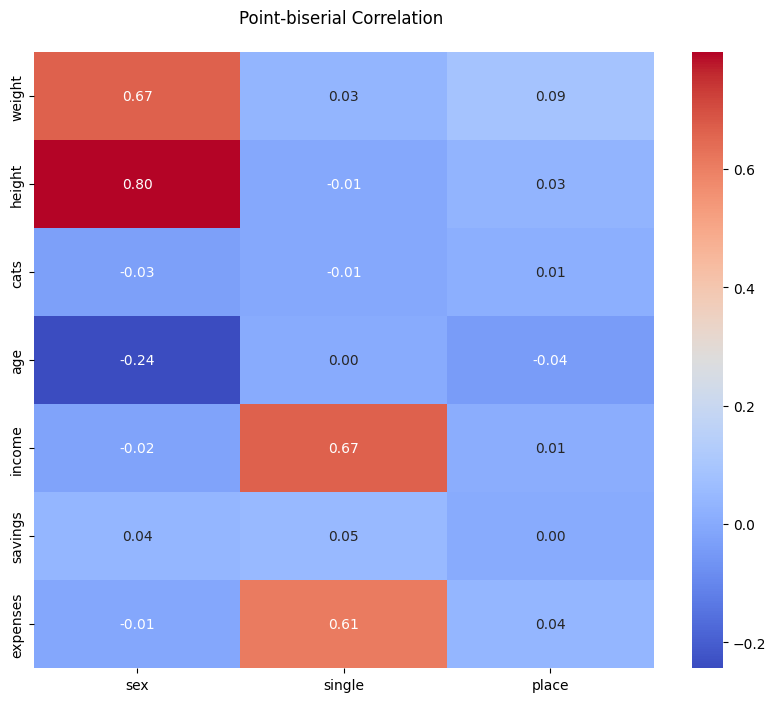

In [70]:
from scipy.stats import pointbiserialr

for p_val in [True, False]:
    
    p_results = np.ones((len(quan_columns), len(qual_columns)))

    for i, x in enumerate(quan_columns):
        for j, y in enumerate(qual_columns):
            corr, p_value = pointbiserialr(df[y], df[x])
            p_results[i][j] = p_value if p_val else corr

    p_results = pd.DataFrame(
        p_results,
        columns = qual_columns,
        index = quan_columns,
    )
    
    if p_val:
        plot_heatmap(p_results, "Point-biserial Correlation (p-values)\n")
    else:
        plot_heatmap(p_results, "Point-biserial Correlation \n")

The more notable correlations are between person's sex and their height and weight. Also there's negative correlation beetween person's age and their sex - usually women live longer then men. Also there's a correlation between being single and income and expenses, which could be explained by single's lifestyle and opportunities.

## Task 3 

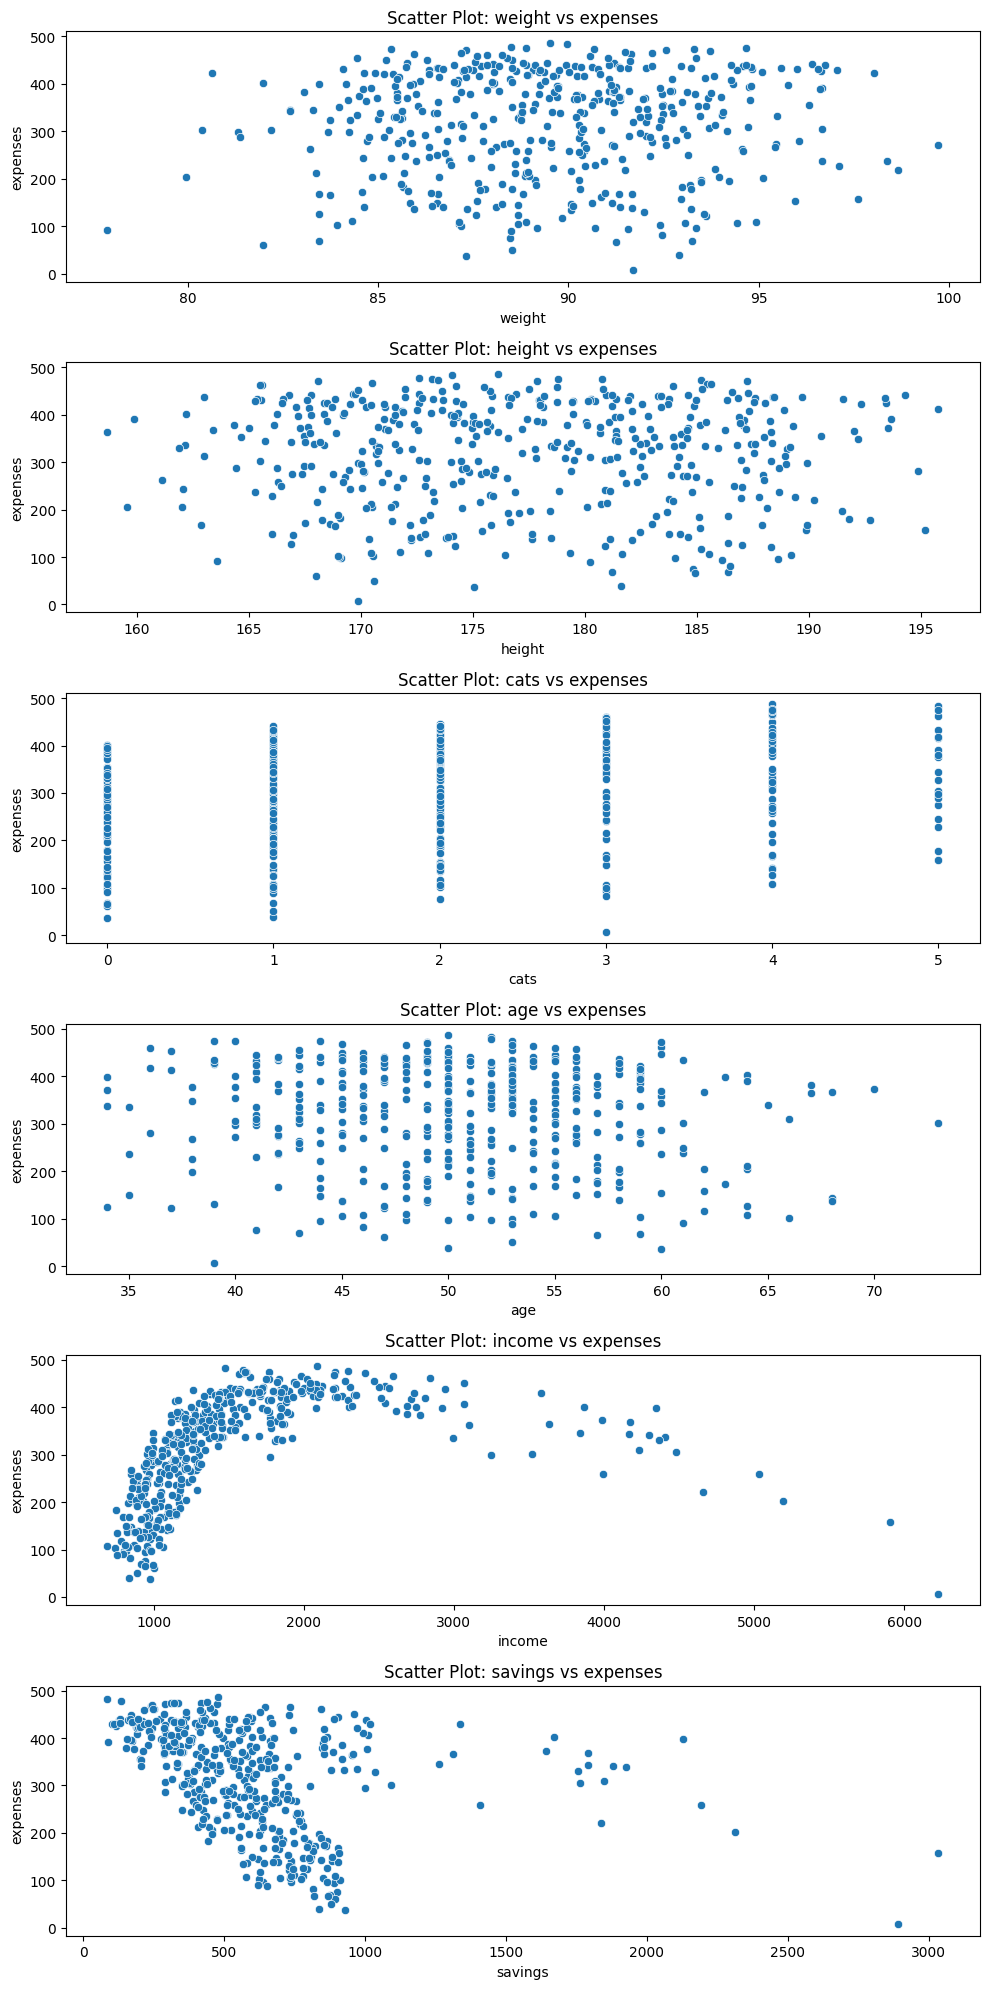

In [71]:
fig, axes = plt.subplots(len(quan_columns) - 1, 1, figsize=(10, 20))
for i, col in enumerate(quan_columns):
    if col != 'expenses':
        sb.scatterplot(data = df, x = col, y = 'expenses', ax = axes[i])
        axes[i].set_title(f'Scatter Plot: {col} vs expenses')
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('expenses')

plt.tight_layout()
plt.show()

The most interesting for me is the plot of income against the expenses. It would seem logical for me that people who earn more money will spend more money (in this case on food, but i would guess it generelizes to every aspect of person's life). It seems that it is not the case. It may be because earning more and more, requires for a person to be responsible about spending.

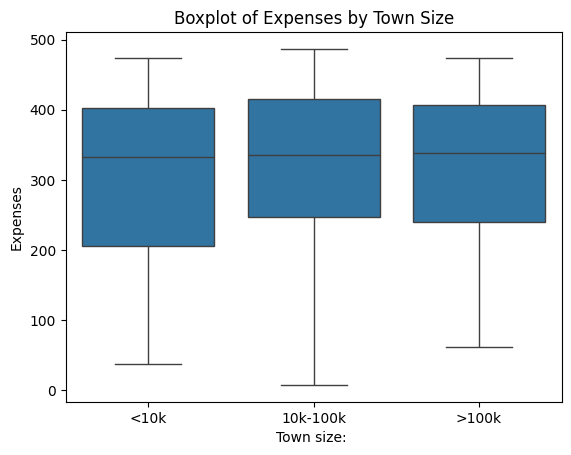

In [72]:
sb.boxplot(data = df, x = 'place', y = 'expenses')
plt.title("Boxplot of Expenses by Town Size")
plt.xticks([0, 1, 2], ['<10k', '10k-100k', '>100k'])
plt.xlabel("Town size: ")
plt.ylabel("Expenses")
plt.show()

It seems that expenses on food are the highest in middle-sized towns. That could be, because people earn more money there, than in smaller towns, so they can spend more. Also the supermarket chain stores, which offer the lowest prices may be harder to find than in the biggest cities.

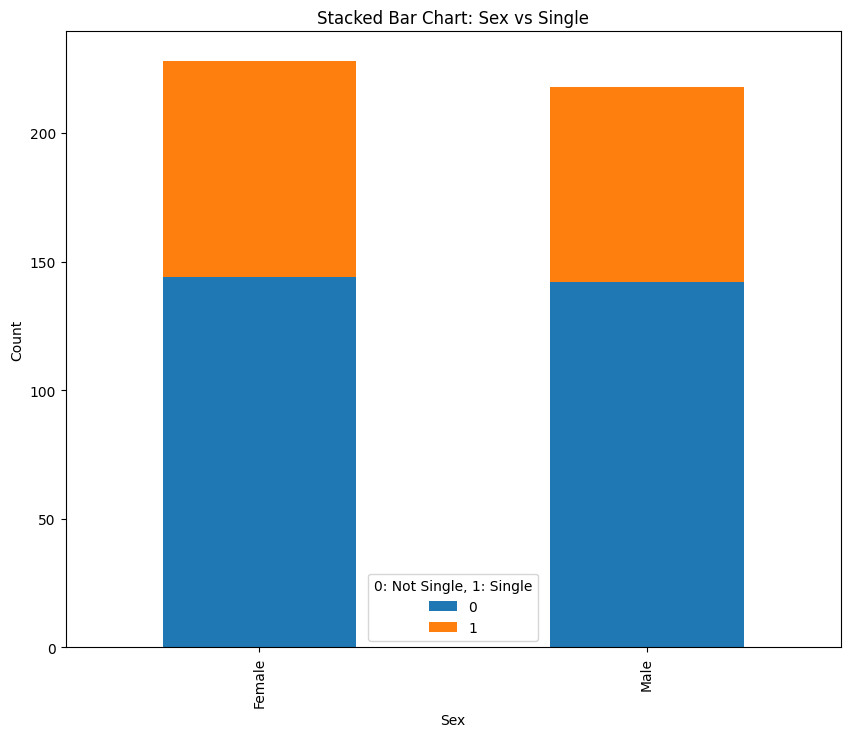

In [73]:
stacked_data = df.groupby(['sex', 'single']).size().unstack()

stacked_data.plot(kind = 'bar', stacked = True, figsize = (10, 8))

plt.title("Stacked Bar Chart: Sex vs Single")
plt.xlabel("Sex")
plt.xticks([0, 1], ['Female', 'Male'])
plt.ylabel("Count")
plt.legend(title="0: Not Single, 1: Single")
plt.show()


Judging from this barplot it would seem that there are proportionally more single females than males across the dataset. I'm not sure how it would look in real-life data, but i think it would be interesting to compare this plot with the same plot for people under 30.

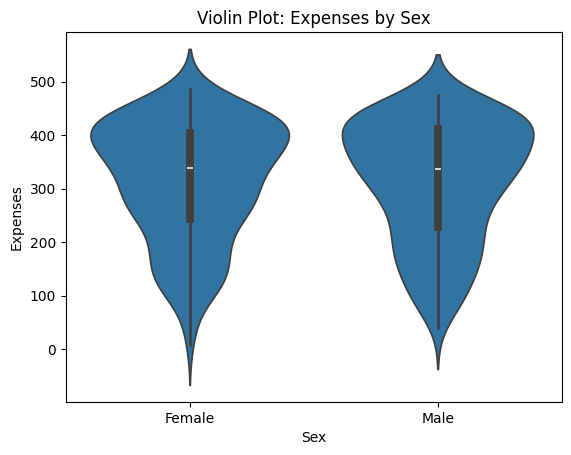

In [74]:
sb.violinplot(data = df, x = 'sex', y = 'expenses')
plt.title("Violin Plot: Expenses by Sex")
plt.ylabel("Expenses")
plt.xlabel("Sex")
plt.xticks([0, 1], ['Female', 'Male'])
plt.show()


Plots seem quite similar, but there seem to be fewer males that have expenses in range 200-300 and more males that have high expenses.

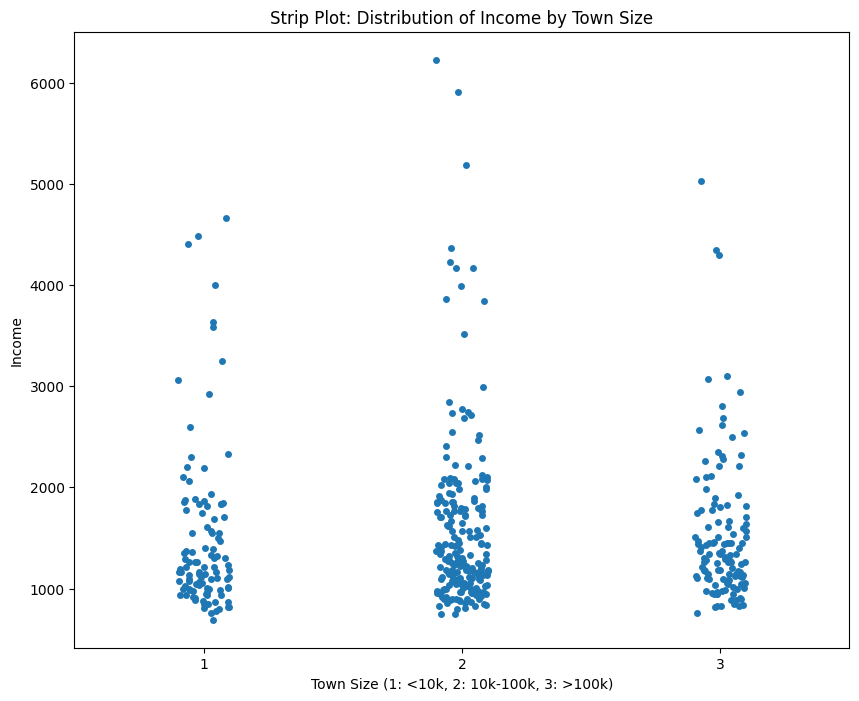

In [75]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.stripplot(
    data = df,
    x = 'place',
    y = 'income',
    jitter = True,
)

plt.title("Strip Plot: Distribution of Income by Town Size")
plt.xlabel("Town Size (1: <10k, 2: 10k-100k, 3: >100k)")
plt.ylabel("Income")
plt.show()

It is interesting to see that people who earn the most, decide to live in a middle-sized towns. That seems counter-intuitive to me. I'd think that most extremly rich people would live in biggest cities centres.

## Task 4

In [76]:
quantiles = [0.25, 0.75, 0.9]
quantiles = [df['income'].quantile(x) for x in quantiles]

classes = ['lower', 'middle', 'upper middle', 'upper']

def assign_wealth_class(income):
    for i, q in enumerate(quantiles):
        if income < q:
            return classes[i]
        
    return classes[-1]

df['wealth_class'] = df['income'].apply(assign_wealth_class)
df.head()

,id,weight,height,sex,cats,age,income,savings,single,place,expenses,wealth_class
0,1,84.99,171.72,1,2,55,1213.10,480.45,0,1,326.33,middle
1,2,91.06,175.83,1,2,41,1300.14,192.14,0,2,409.24,middle
2,3,88.30,175.34,1,1,42,1203.19,643.34,0,3,274.26,middle
3,4,84.51,167.64,1,1,50,1231.13,303.35,0,1,374.86,middle
4,5,85.72,171.62,1,2,53,892.02,424.99,0,2,248.24,lower


In [77]:
# Using std dev as a measure of variability 
std_expenses_by_class = df.groupby('wealth_class')['expenses'].std()
print("Standard Deviation of Expenses by Wealth Class:")
print(std_expenses_by_class)


Standard Deviation of Expenses by Wealth Class:
wealth_class
lower           73.058353
middle          78.711063
upper           90.626161
upper middle    35.302295
Name: expenses, dtype: float64


Both lower and middle class have similar variability in their expenses on food. This may indicate that their expenses vary and aren't that easy to predict based just on income alone.

Upper middle class has lowest variability in their expenses. People in this group probably have higher and more stable income, so their patterns of spending money on food is more regular.

Upper class has highest variability in expenses on food and it is what i would expect. Some of people in this class probably spend huge amounts of money on luxorius food, while some may just buy standard products from grocery store.

## Task 5

#### Do women declare higher savings than men 

To determine whether women declare higher savings than men, we will perform a Mann-Whitney U test, because it seems that women and men savings do not resemble normal disribution (we use Kolmogorov-Smirnov test due to the sample being larger than 50 observations).

Null Hypothesis (H₀): Women and men declare equal savings.
Alternative Hypothesis (H₁): Women declare different savings than men.

Justification for Using Mann-Whitney U Test:

- The savings data for both groups is not normally distributed, as confirmed by the Shapiro-Wilk normality test.

In [78]:
from scipy.stats import kstest

women_savings = df[df['sex'] == 1]['savings']
men_savings = df[df['sex'] == 2]['savings']
statistic_women, p_value_women = kstest(
    women_savings,
    'norm',
    args = (
        women_savings.mean(),
        women_savings.std(),
    ),
)
statistic_men, p_value_men = kstest(
    men_savings,
    'norm',
    args = (
        men_savings.mean(),
        men_savings.std(),
    ),
)
print("Testing p-value")
print("Kolmogorov-Smirnov test for women:", p_value_women)
print("Kolmogorov-Smirnov test for men:", p_value_women)

# Seems that it's not normally distributed.


Testing p-value
Kolmogorov-Smirnov test for women: 0.0031925019019093575
Kolmogorov-Smirnov test for men: 0.0031925019019093575


##

In [83]:
from scipy.stats import mannwhitneyu 

stat, p_value = mannwhitneyu(women_savings, men_savings, alternative='two-sided')
print(f"Mann-Whitney U statistic: {stat}, P-value: {p_value}")

if p_value > 0.01:
    print("In this case null hypothesis cannot be rejected.")
    print("The difference in declared savings between women and men \nis not statistically significant.")

Mann-Whitney U statistic: 22957.0, P-value: 0.16382868205857948
In this case null hypothesis cannot be rejected.
The difference in declared savings between women and men 
is not statistically significant.


#### Is the mean weight of women greater than 56 kg?

To determine whether the mean weight of women is greater than 56 kg, we can perform a one-sample t-test.

Null Hypothesis: The mean weight of women is less than or equal to 56 kg.

Alternative Hypothesis: The mean weight of women is greater than 56 kg.

Assumptions:

- The weight data of women is approximately normally distributed.
- The observations are independent of each other.
- The weight data is measured on an interval or ratio scale.

Why one sample t-test is approperiate?
- There is a single group and we want to compare it to a known value.

Kolmogorov-Smirnov test for women weight (p_value) 0.9019605510120549


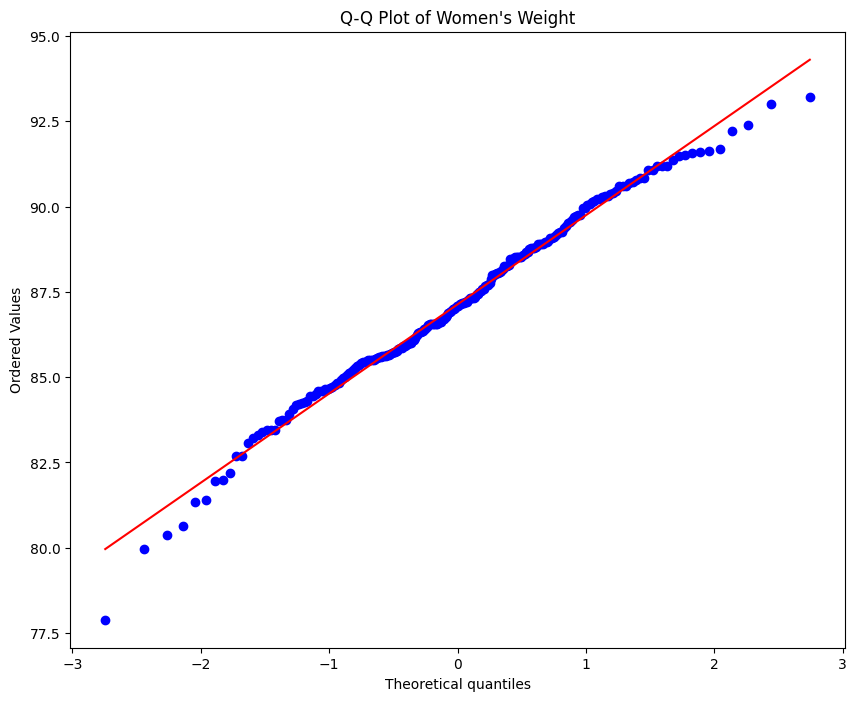

In [80]:
from scipy.stats import kstest

women_weight = df[df['sex'] == 1]['weight']
statistic_women, p_value_women = kstest(
    women_weight,
    'norm',
    args = (
        women_weight.mean(),
        women_weight.std(),
    ),
)
print("Kolmogorov-Smirnov test for women weight (p_value)", p_value_women)

plt.figure(figsize=(10, 8))
stats.probplot(women_weight, dist="norm", plot=plt)
plt.title('Q-Q Plot of Women\'s Weight')
plt.show()
# Seems that it's normally distributed.


In [81]:
from scipy.stats import ttest_1samp

t_stat, p_value = ttest_1samp(women_weight, 56)
 
# It's a one-tailed test, so dividing the p-value by 2
p_value_one_tailed = p_value / 2

print(f"t-statistic: {t_stat}")
print(f"p-value (one-tailed): {p_value_one_tailed}")

# significance level
alpha = 0.01
if p_value_one_tailed < alpha:
    print("Reject the null hypothesis: Mean weight of women is greater than 56 kg.")
else:
    print("Fail to reject the null hypothesis")


t-statistic: 180.39754641727836
p-value (one-tailed): 2.1176805224740763e-247
Reject the null hypothesis: Mean weight of women is greater than 56 kg.


#### Does a lower proportion of food expenses to income correlate with higher savings?

To determine if a lower proportion of food expenses to income correlates with higher savings, we perform a correlation analysis. We will compute the Spearman rank correlation.

Null Hypothesis: There is no correlation between the proportion of food expenses to income and savings.

Alternative Hypothesis: There is a negative correlation between the proportion of food expenses to income and savings.

Why Spearman Correlation is approperiate:
- Both variables are continuous and not necessarily have a linear relationship.

In [114]:
from scipy.stats import spearmanr

df['food_expense_to_income'] = df['expenses'] / df['income']
spearman_corr, p_value = spearmanr(df['food_expense_to_income'], df['savings'])

stat, pval_exp = kstest(
    df['food_expense_to_income'],
    'norm',
    args = (
        df['food_expense_to_income'].mean(),
        df['food_expense_to_income'].std(),
    ),
)
_, pval_sav = kstest(
    df['savings'],
    'norm',
    args = (
        df['savings'].mean(),
        df['savings'].std(),
    ),
)
print("Testing p-value")
print("Kolmogorov-Smirnov test for expenses to income:", pval_exp)
print("Kolmogorov-Smirnov test for savings:", pval_sav)
print("")

print(f"Spearman rank correlation coefficient: {spearman_corr}")
print(f"P-value: {p_value}")

print("There is", end='')
if p_value < 0.01:
    print(" a", end='')
else:
    print(" no", end='')
print(" statistically significant monotonic relationship between food expenses divided by income and savings.")

Testing p-value
Kolmogorov-Smirnov test for expenses to income: 0.01595673506858252
Kolmogorov-Smirnov test for savings: 4.987922928886582e-06

Spearman rank correlation coefficient: -0.7517251267498376
P-value: 2.665117961225395e-82
There is a statistically significant monotonic relationship between food expenses divided by income and savings.


#### Verify an additional (sensible) hypothesis on the goodness-of-fit with a given (sensible) parametric distribution for the selected variable (e.g., ”variable A has a Poisson distribution with parameter 1”)

Example Hypothesis:

Let’s assume that "the number of cats in the household" follows a Poisson distribution with a parameter $\lambda$ equal to the mean of the observed data.

Null Hypothesis: The variable "cats" follows a Poisson distribution with $\lambda$ mean of observed data $\lambda$ = mean. 

Alternative Hypothesis: The variable "cats" does not follow a Poisson distribution with $\lambda$  = mean. 

Goodness-of-Fit Test:
- Chi-Square goodness-of-fit test can evaluate whether the observed frequencies differ significantly from the expected frequencies under the Poisson assumption.

Assumtions:
- Both variables are categorical
- All observations are independent.

In [106]:
from scipy.stats import chisquare, poisson

cats_data = df['cats'] 
lambda_poisson = np.mean(cats_data)

observed_counts = np.bincount(cats_data)  
categories = np.arange(len(observed_counts))  

expected_counts = len(cats_data) * poisson.pmf(categories, lambda_poisson)
expected_counts = expected_counts * (observed_counts.sum() / expected_counts.sum())

chi2_stat, p_value = chisquare(f_obs = observed_counts, f_exp = expected_counts)

alpha = 0.01 
if p_value > alpha:
    print("Accepting null hypothesis: The data fits a Poisson distribution.")


0.12866286888238881
Accepting null hypothesis: The data fits a Poisson distribution.


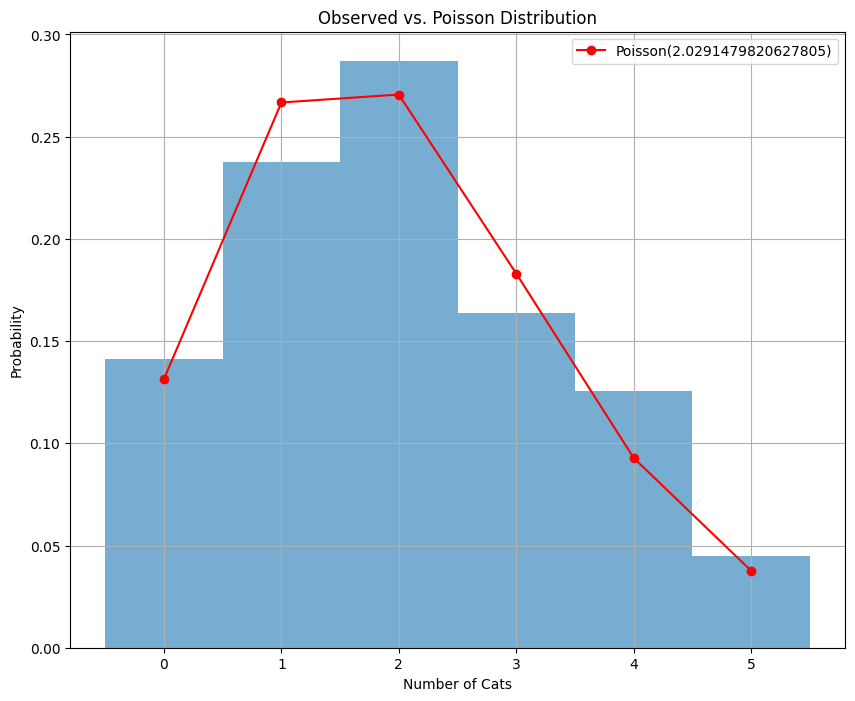

In [109]:
x_vals = np.arange(0, max(cats_data) + 1) 
poisson_pmf = poisson.pmf(x_vals, lambda_poisson)

plt.figure(figsize=(10, 8))
plt.hist(
    cats_data,
    bins = np.arange(-0.5, max(cats_data) + 1.5),
    density=True,
    alpha=0.6,
)
plt.plot(
    x_vals,
    poisson_pmf,
    color = 'red',
    marker = 'o',
    label = f'Poisson({lambda_poisson})'
)

# Labels and legend
plt.title("Observed vs. Poisson Distribution")
plt.xlabel("Number of Cats")
plt.ylabel("Probability")
plt.legend()
plt.grid()

plt.show()

## Task 6

In [119]:
import statsmodels.api as sm

# single is already encoded
df["sex"] = df["sex"].replace({1: "female", 2: "male"})
df["place"] = df["place"].replace({1: "small", 2: "medium", 3: "large"})

df_encoded = pd.get_dummies(df, drop_first = True)

X = df_encoded.drop(columns=["expenses"]).astype(float)
y = df_encoded["expenses"].astype(float)

X = sm.add_constant(X)

model = sm.OLS(y, X).fit()

print(model.summary())


                            OLS Regression Results                            
Dep. Variable:               expenses   R-squared:                       0.933
Model:                            OLS   Adj. R-squared:                  0.930
Method:                 Least Squares   F-statistic:                     398.2
Date:                Tue, 24 Dec 2024   Prob (F-statistic):          3.70e-241
Time:                        23:39:02   Log-Likelihood:                -2128.6
No. Observations:                 446   AIC:                             4289.
Df Residuals:                     430   BIC:                             4355.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 